# 导入工具包

In [1]:
# 数据读取及基本处理
import pandas as pd
import numpy as np

#查看数据分布是否对称/计算斜度/是否需要log或
from scipy.stats import skew

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
# 显示文件图片
from IPython.display import display
# float显示三位小数 
pd.set_option('display.float_format', lambda x: '%.3f' % x) 
from zhou_utils.utils_zhou import *
%matplotlib inline

In [8]:
# 设置一些全局的资源参数，可以进行个性化修改
import matplotlib

matplotlib.rc('figure', figsize = (10, 6))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

# 导入数据

In [3]:
data = pd.read_csv("./data/day.csv")
test = data[data.yr ==1] # 2012年做待预测数据
test = test.drop(["yr", "dteday"], axis=1)


data = data[data.yr ==0] # 2011年做数据分析
data = data.drop(["yr", "dteday"], axis=1)
data.head()

,instant,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,1,0,6,0,2,0.344,0.364,0.806,0.160,331,654,985
1,2,1,1,0,0,0,2,0.363,0.354,0.696,0.249,131,670,801
2,3,1,1,0,1,1,1,0.196,0.189,0.437,0.248,120,1229,1349
3,4,1,1,0,2,1,1,0.200,0.212,0.590,0.160,108,1454,1562
4,5,1,1,0,3,1,1,0.227,0.229,0.437,0.187,82,1518,1600


# 数据探索

## 基本信息

In [4]:
show_number_describe(data)

共有：[365]条样本，特征数为：[14]，其中有[14]个特征是number
使用内存大小为: [42.77] KB


,count,mean,std,min,25%,50%,75%,max,dif_vals,dtype,num_null
instant,365,183.000,105.511,1.000,92.000,183.000,274.000,365.000,365,int64,0
season,365,2.499,1.111,1.000,2.000,3.000,3.000,4.000,4,int64,0
mnth,365,6.526,3.453,1.000,4.000,7.000,10.000,12.000,12,int64,0
holiday,365,0.027,0.163,0.000,0.000,0.000,0.000,1.000,2,int64,0
weekday,365,3.008,2.006,0.000,1.000,3.000,5.000,6.000,7,int64,0
workingday,365,0.685,0.465,0.000,0.000,1.000,1.000,1.000,2,int64,0
weathersit,365,1.422,0.572,1.000,1.000,1.000,2.000,3.000,3,int64,0
temp,365,0.487,0.190,0.059,0.325,0.479,0.657,0.849,294,float64,0
atemp,365,0.467,0.169,0.079,0.322,0.473,0.612,0.841,353,float64,0
hum,365,0.644,0.149,0.000,0.538,0.647,0.742,0.973,332,float64,0


共16列特征, 目标为casual, registered, cnt 

* 无object型数据: "dteday"(dteday看做连续型)

* continuous型数据:  "cnt", "registered", "casual", "windspeed", "hum", "atemp", "temp", "instant"

* discrete型数据: "season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit"
 
* target = "cnt"

* index = "instant"

 无nan

## 单变量分布--num

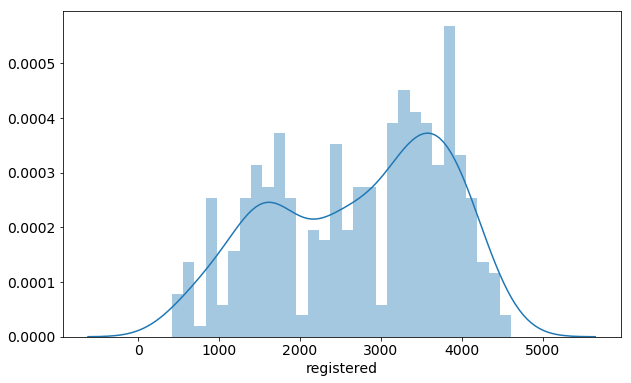

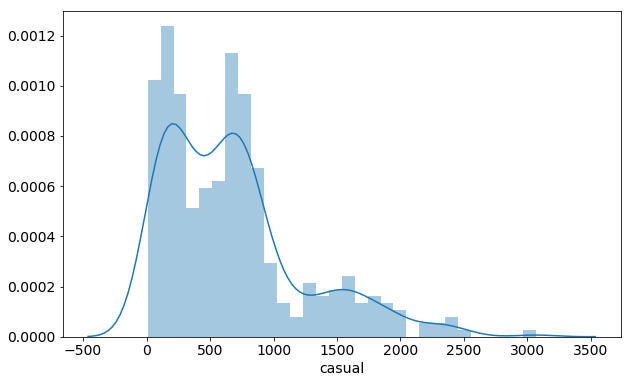

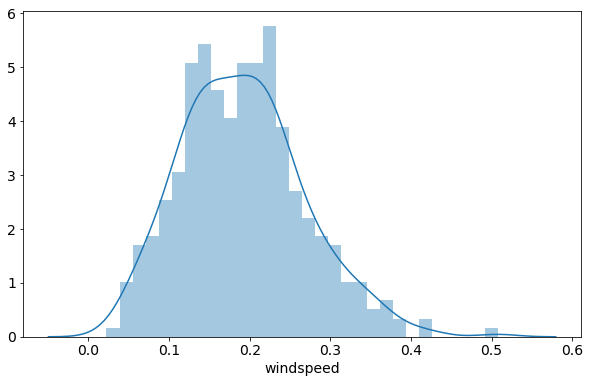

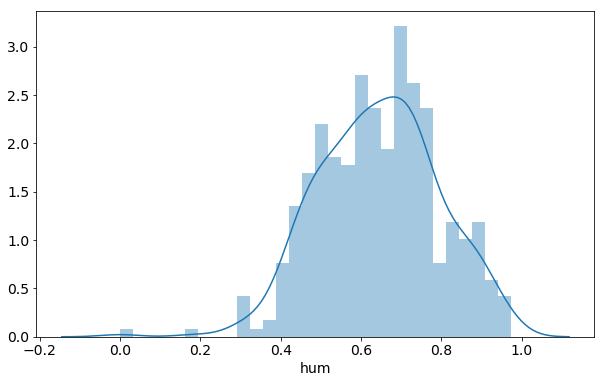

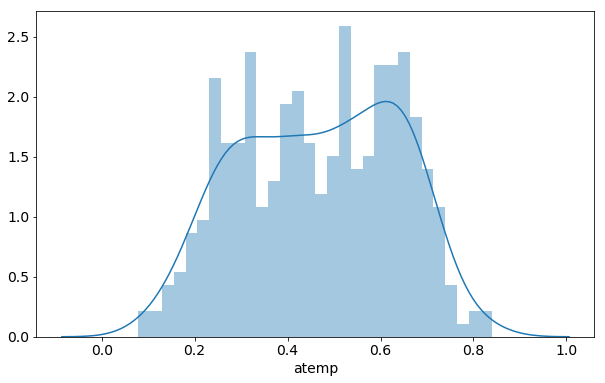

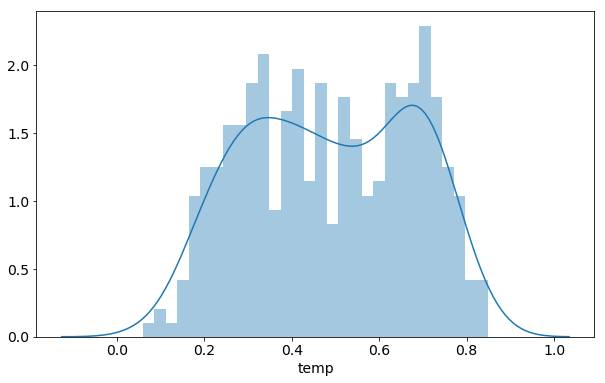

In [12]:
# 特征名
data_nums = ["registered", "casual", "windspeed",
              "hum", "atemp", "temp",] 

for col in data_nums:
    sns.distplot(data[col], kde=True, bins=30)   #这个的直方图无意义
    plt.xlabel(col)
    plt.show()

## 单变量分布--obj

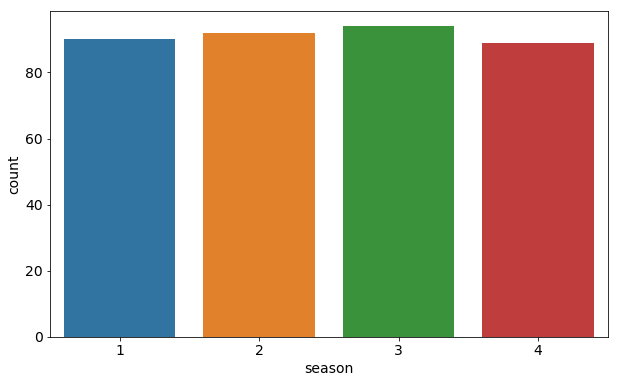

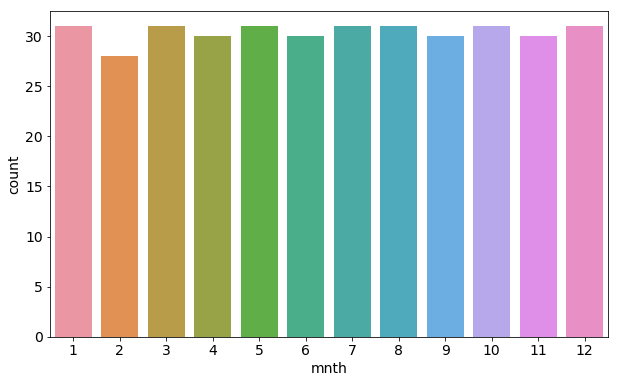

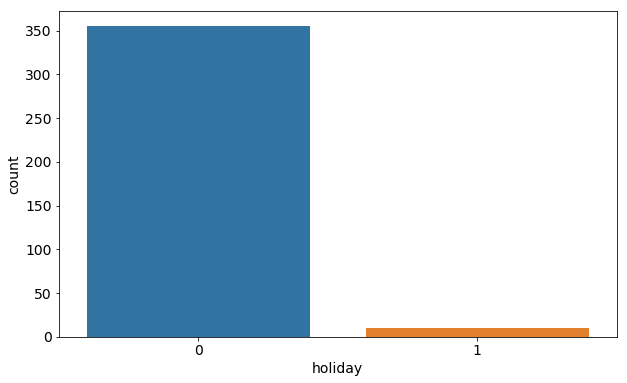

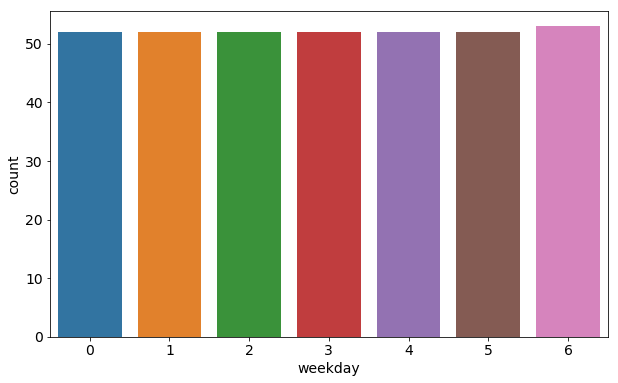

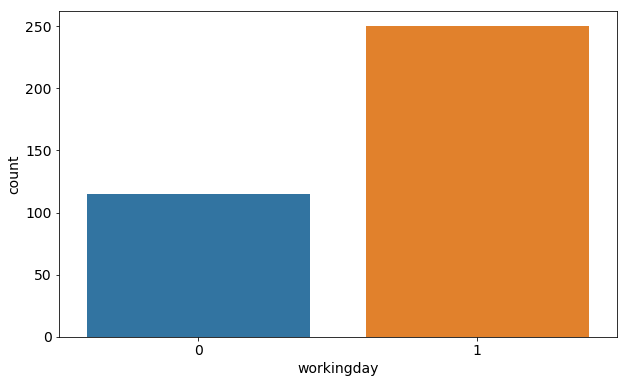

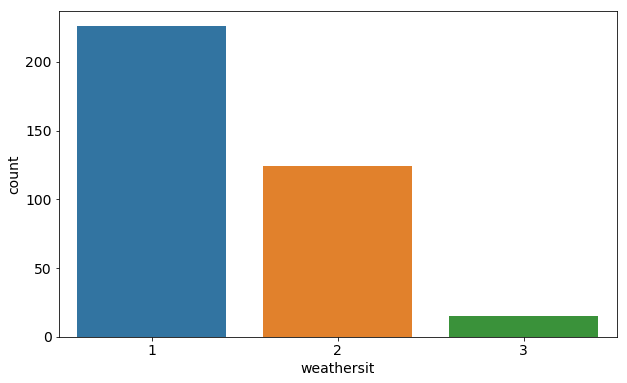

In [11]:
# 特征名
data_objs = ["season", "mnth", "holiday", 
             "weekday", "workingday", "weathersit"] 

for col in data_objs:
    sns.countplot(data[col],) 
    plt.xlabel(col)
    plt.show()

## target与X

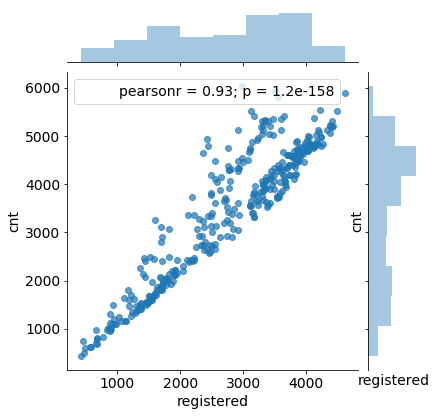

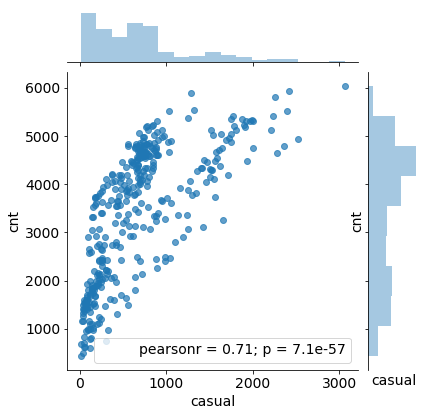

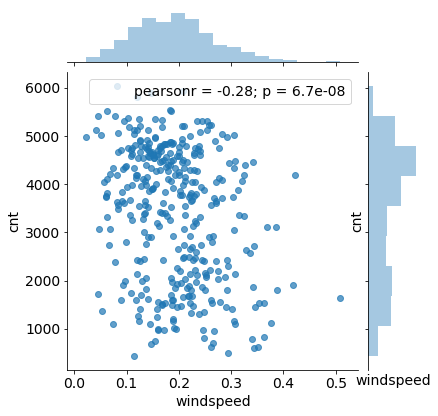

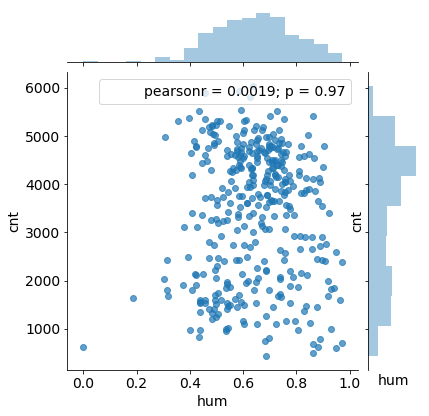

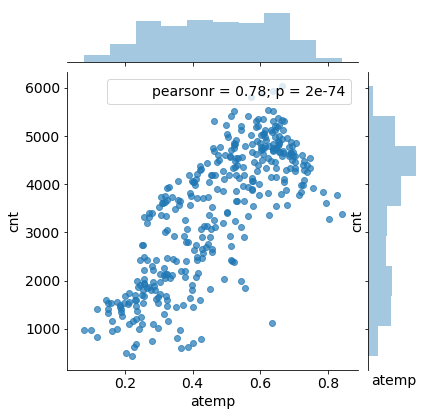

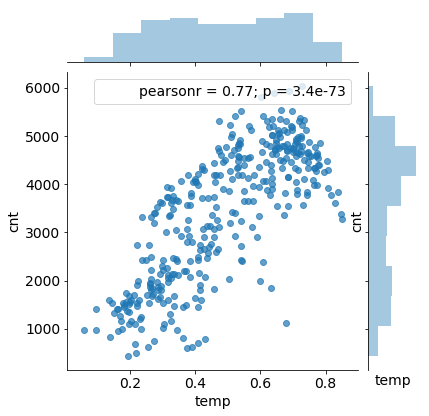

In [13]:
# 查看num变量与target之间的关系
for col in data_nums:
    sns.jointplot(x=col, y="cnt", data=data, alpha=0.7)
    plt.xlabel(col)
    plt.ylabel("cnt")
    plt.show()

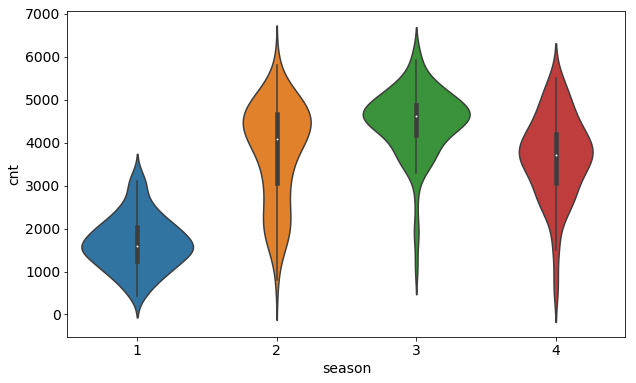

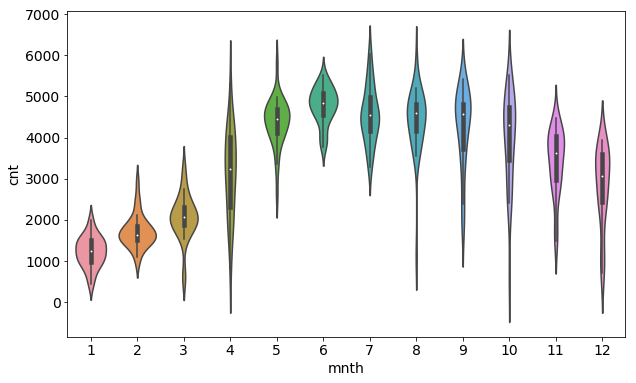

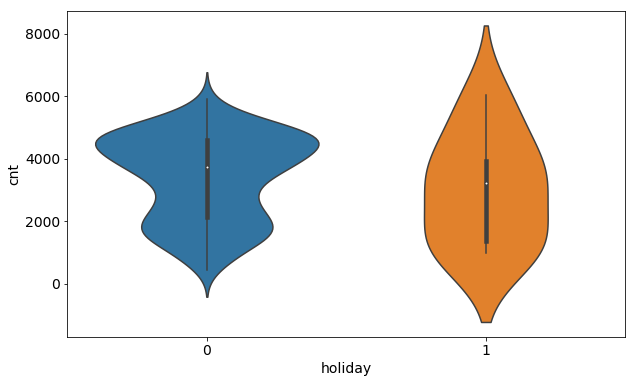

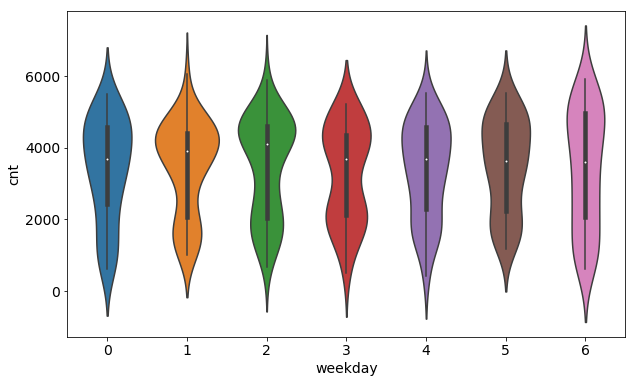

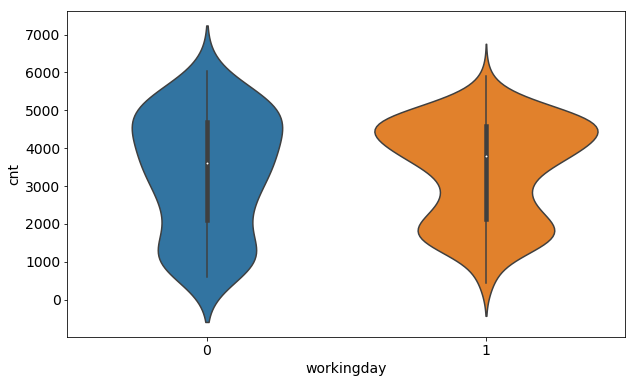

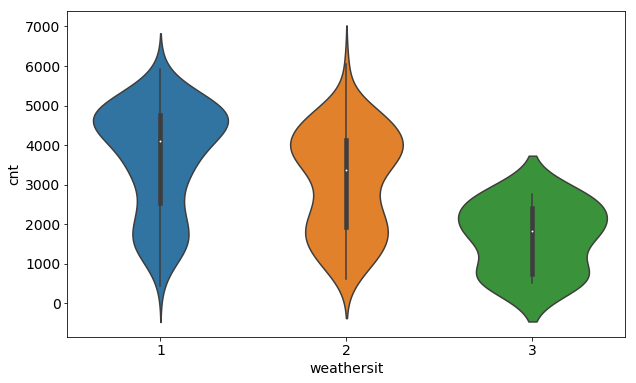

In [14]:
# 查看obj变量与target之间的关系
for col in data_objs:
    sns.violinplot(x=col, y="cnt", data=data,)
    plt.xlabel(col)
    plt.ylabel("cnt")
    plt.show()

## 相关性

In [18]:
data_num_corr = data[data_nums].corr().abs() #相关性矩阵
size = data_num_corr.shape[1] # for上界
cols = list(data_num_corr.columns) # 相关性矩阵特征名
threshold = 0.6 # 相关性分界线
data_corr_list = [] # 相关性大小排序list
# 格式为: [相关性大小, 特征名[i],特征名[j]]

for i in range(0, size):
    for j in range(i+1, size): # 对称矩阵,取一半
        data_corr_list.append([data_num_corr.iloc[i,j], i, j])
# 按相关性大小进行排序
data_corr_list = sorted(data_corr_list,key=lambda x:-x[0])
# 输出相关性大于threshold的特征
for v,i,j in data_corr_list:
    if v > threshold:
        print("%3.3f is %s and %s" % (v,cols[i],cols[j])) 
#       记得加括号(cols[i],cols[j],v)


0.996 is atemp and temp
0.703 is registered and atemp
0.698 is registered and temp


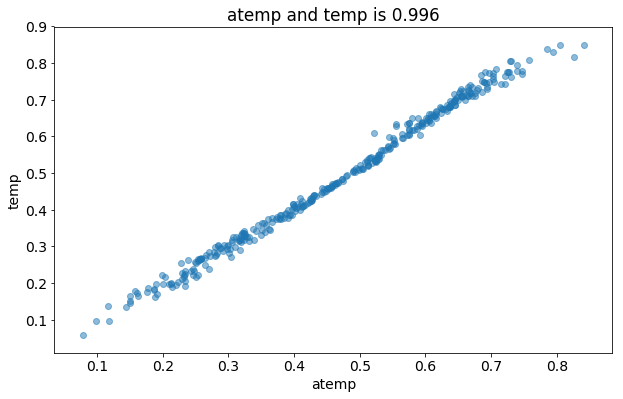

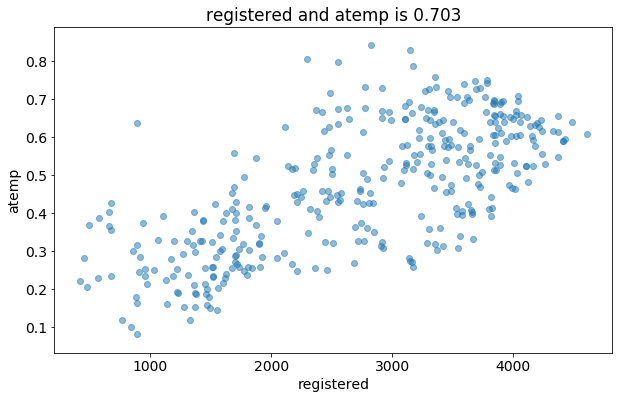

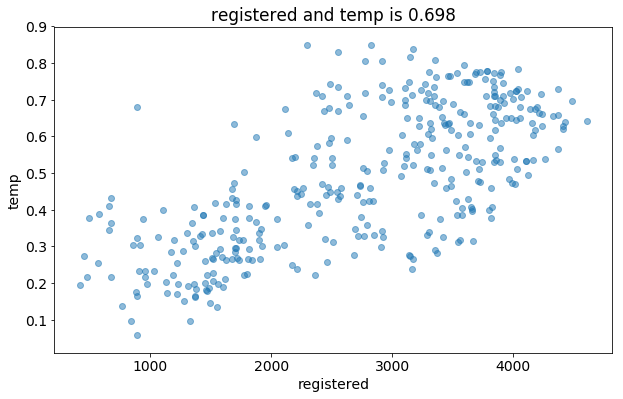

In [19]:
# 相关性大于threshold 特征之间的散点图
for v,i,j in data_corr_list:
    if v > threshold:
        plt.scatter(data[cols[i]], data[cols[j]], alpha=0.5)
        plt.xlabel(cols[i])
        plt.ylabel(cols[j])
        plt.title("%s and %s is %3.3f" % (cols[i],cols[j],v)) 
        plt.show()  